In [59]:
import gzip
import json
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from random import randrange, shuffle

# Parsing the provided GoodReads books dataset

In [70]:
NUM_OF_BOOKS = 200000
RANDOM_SEED = 11
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

random.seed(RANDOM_SEED)
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [71]:
def is_non_empty_string(text):
    return text is not None and text != ""

In [72]:
def load_first_n_english_books(file_name, n=10):
    count = 0
    books = []
    with gzip.open(file_name) as fin:
        for l in fin:
            book = json.loads(l)
            if book['language_code'] == 'eng' and is_non_empty_string(book['title']) and is_non_empty_string(book['description']):
                count += 1
                books.append(book)
            
            if count >= n:
                break
    
    return books

In [73]:
books_raw = load_first_n_english_books('data/goodreads_books.json.gz', NUM_OF_BOOKS)

In [74]:
def extract_features_of_interest(books):
    result = {}
    for book in books:
        result[book['book_id']] = {
                'book_id': book['book_id'],
                'title': book['title'],
                'description': book['description'].replace('\n', ' '),
                'similar_books': book['similar_books']
            }
            
    return result

In [75]:
books = extract_features_of_interest(books_raw)

In [76]:
def filter_out_similar_books_out_of_scope_(books):
    for book_id in books:
        book = books[book_id]
        book['similar_books'] = [similar_book for similar_book in book['similar_books'] if similar_book in books]

In [77]:
filter_out_similar_books_out_of_scope_(books)

In [78]:
print(f'Number of books: {len(books)}')

Number of books: 200000


In [79]:
print('Example book:')
print(json.dumps(list(books.values())[35], indent=4))

Example book:
{
    "book_id": "16693030",
    "title": "A Monster Calls",
    "description": "An unflinching, darkly funny, and deeply moving story of a boy, his seriously ill mother, and an unexpected monstrous visitor. At seven minutes past midnight, thirteen-year-old Conor wakes to find a monster outside his bedroom window. But it isn't the monster Conor's been expecting-- he's been expecting the one from his nightmare, the nightmare he's had nearly every night since his mother started her treatments. The monster in his backyard is different. It's ancient. And wild. And it wants something from Conor. Something terrible and dangerous. It wants the truth. From the final idea of award-winning author Siobhan Dowd-- whose premature death from cancer prevented her from writing it herself-- Patrick Ness has spun a haunting and darkly funny novel of mischief, loss, and monsters both real and imagined.",
    "similar_books": [
        "6369113",
        "10165727",
        "10836471",
     

In [80]:
with open(f'data/top_{len(books)}_eng_books_filtered.json', 'w') as books_json_file:
    json.dump(books, books_json_file, indent=4)

# Constructing training pairs of similar and non similar books

In [81]:
def construct_book_pair(book1, book2, target_class):
    return {
        'book1_id': book1['book_id'],
        'book1_title': book1['title'],
        'book1_description': book1['description'],
        'book2_id': book2['book_id'],
        'book2_title': book2['title'],
        'book2_description': book2['description'],
        'target_class': target_class
    }

In [82]:
def construct_book_pairs(books):
    pairs = []

    # Actual similar books hence target class 1
    for book_id in books:
        book = books[book_id]
        for similar_book_id in book['similar_books']:
            similar_book = books[similar_book_id]
            pairs.append(construct_book_pair(book, similar_book, 1))
    
    # The same number of randomly selected books to form pair of target class 0
    num_of_similar_book_pairs = len(pairs)
    num_of_books = len(books)
    book_ids = list(books.keys())
    for _ in range(num_of_similar_book_pairs):
        book1_id = book_ids[randrange(num_of_books)]
        book2_id = book_ids[randrange(num_of_books)]
        pairs.append(construct_book_pair(books[book1_id], books[book2_id], 0))

    shuffle(pairs)
    return pairs

In [83]:
pairs = construct_book_pairs(books)

In [84]:
print(f'Number of book pairs: {len(pairs)}')
print('Example pair:')
print(json.dumps(pairs[14], indent=4))

Number of book pairs: 552128
Example pair:
{
    "book1_id": "21524278",
    "book1_title": "Charming the Duke",
    "book1_description": "1849 . . . Matilda Sheldon, the middle daughter of the sixth Earl of Bisset, has never been interested in the fashionable society events that so preoccupy her parents and siblings. Her loving, albeit, daft family cannot understand why. But Matilda has little use for silly rules and dramas. She would rather occupy her time with a worthwhile cause such as opening The Sheldon Home for Orphans, much to the chagrin of her mother and grandmother. They are quite certain a venture of this nature will discourage suitors. Matilda is quite certain that if suitors are discouraged it is because she is clever, plain, a bit clumsy, and inevitably compared to her beautiful sisters. The Duke of Thornsby is in tight spot. After receiving the title on the death of his father, he discovers the inheritance is to be gifted elsewhere if he does not marry before his thirti

In [87]:
pairs_df = pd.DataFrame(pairs)
pairs_df.index.name = 'pair_id'

In [89]:
print(f'Dataframe shape: {pairs_df.shape}')
pairs_df.head(30)

Dataframe shape: (552128, 7)


,book1_id,book1_title,book1_description,book2_id,book2_title,book2_description,target_class
pair_id,,,,,,,
0,15984348,"X-Men, by Brian Wood, Volume 1: Blank Generation",Superstar writer Brian Wood (Wolverine & the X...,16002124,"Astonishing X-Men, Volume 11: Weaponized",It's the explosive aftermath to the year's mos...,1
1,15779244,"1971 (Mark Miller's One, #10)",100% of the author's proceeds will be donated ...,18270710,The Tiger (The Donkey and the Wall #3),"""Lost and found..."" The Tiger chronicles the L...",0
2,17338329,"Beware of Bad Boy (Beware of Bad Boy, #1)","**Ebook FREE on Amazon, iTunes, Google Play an...",17611210,The Mistress Mistake,Jessica Conway is at the end of her rope. She ...,1
3,32329580,"Fur (Becoming, #1)",Have you ever wondered what it's like to becom...,12434408,"Goodnight, Angels","Goodnight, rubber duckie. Thank you for the sc...",0
4,18584581,Exposed,Nia doesn't know why the TV show Dirty Rotten ...,17665070,Unearthing Cole,Cole Alston swore he'd never return to his chi...,0
5,30282842,Day Dreamer (Undeadly Secrets Book 2),Alex Hensley thought that discovering vampires...,12042965,Raphael's Mating,[Siren Classic ManLove: Erotic Alternative Par...,0
6,417803,"Shooting Chant (Ella Clah, #5)",Navajo Police Special Investigator Ella Clah i...,22022427,When Lines Are Blurred,J2 Fanfic High school au in which Jensen Ackle...,0
7,21531497,The Laughing Monsters,Denis Johnson's The Laughing Monsters is a hig...,18490553,American Innovations: Stories,A brilliant new collection of short stories fr...,1
8,19462885,"The Adventure Continues (Adventure, #2)",Rose and Ian were a match made in heaven. Or s...,25088474,Senses Series Box Set (Senses #1-5),This box set contains Senses Series Books 1-5....,0


In [90]:
pairs_df = pairs_df.drop_duplicates(subset=['book1_id', 'book2_id'])

In [91]:
print(f'Dataframe shape after removing duplicates: {pairs_df.shape}')
pairs_df.head(30)

Dataframe shape after removing duplicates: (552126, 7)


,book1_id,book1_title,book1_description,book2_id,book2_title,book2_description,target_class
pair_id,,,,,,,
0,15984348,"X-Men, by Brian Wood, Volume 1: Blank Generation",Superstar writer Brian Wood (Wolverine & the X...,16002124,"Astonishing X-Men, Volume 11: Weaponized",It's the explosive aftermath to the year's mos...,1
1,15779244,"1971 (Mark Miller's One, #10)",100% of the author's proceeds will be donated ...,18270710,The Tiger (The Donkey and the Wall #3),"""Lost and found..."" The Tiger chronicles the L...",0
2,17338329,"Beware of Bad Boy (Beware of Bad Boy, #1)","**Ebook FREE on Amazon, iTunes, Google Play an...",17611210,The Mistress Mistake,Jessica Conway is at the end of her rope. She ...,1
3,32329580,"Fur (Becoming, #1)",Have you ever wondered what it's like to becom...,12434408,"Goodnight, Angels","Goodnight, rubber duckie. Thank you for the sc...",0
4,18584581,Exposed,Nia doesn't know why the TV show Dirty Rotten ...,17665070,Unearthing Cole,Cole Alston swore he'd never return to his chi...,0
5,30282842,Day Dreamer (Undeadly Secrets Book 2),Alex Hensley thought that discovering vampires...,12042965,Raphael's Mating,[Siren Classic ManLove: Erotic Alternative Par...,0
6,417803,"Shooting Chant (Ella Clah, #5)",Navajo Police Special Investigator Ella Clah i...,22022427,When Lines Are Blurred,J2 Fanfic High school au in which Jensen Ackle...,0
7,21531497,The Laughing Monsters,Denis Johnson's The Laughing Monsters is a hig...,18490553,American Innovations: Stories,A brilliant new collection of short stories fr...,1
8,19462885,"The Adventure Continues (Adventure, #2)",Rose and Ian were a match made in heaven. Or s...,25088474,Senses Series Box Set (Senses #1-5),This box set contains Senses Series Books 1-5....,0


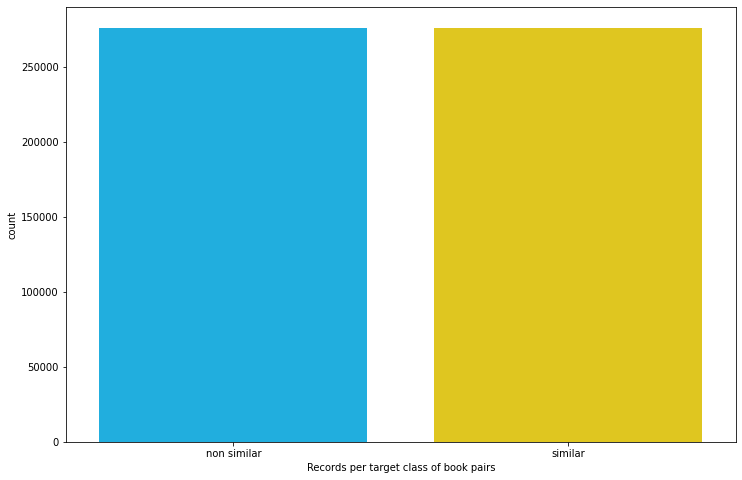

In [92]:
ax = sns.countplot(x=pairs_df['target_class'])
plt.xlabel('Records per target class of book pairs')
ax.set_xticklabels(['non similar', 'similar']);

In [93]:
pairs_df.to_csv('data/similar_book_pairs.csv')
print(f'Book pairs dataframe serialized to CSV successfully.')

Book pairs dataframe serialized to CSV successfully.
